# Group Meeting 10 

Readings: N/A

## Estimating Information-Theoretic Measures from Data

While the purely theoretical use of Information Theory is very interesting, as scientists we typically want to get our hands dirty using Information Theory to actually describe and model the world around us using data that we have collected. Unfortunately, three significant issues present themselves to the would-be modeler:

1) The need for extremely large datasets 

2) Intrinsic Bias in Entropy and Mutual Information 

3) The problem of continuous data

### The Need for Large Datasets

This is arguably the biggest hurdle: as the size of the system under study expands, the size of the associated joint-probability space balloons exponentially. For example, if we want to calculate the joint-entropy of a 2-element process, we need 4 joint-states ([00, 01, 10, 11]), but for a 5 element process, we need 32 joint-states. In general, for a process with $M$ states and $N$ elements, the size of the joint state-space grows with $M^N$.

Consequently, to get good estimates of the joint-probability of each realization, you really need a large number of instances. The exact number you need varies, but if you find yourself with only 1-10 instances of a particular combination of states, that is likely too few to be confident that you have inferred a reliable probability. If you have data with a large number of interacting elements, each of which can take on a large number of states, you need mountains of data to be confident that what you're seeing is "real." Unfortunately, the measures will return numbers no matter how sparse your data, or joint-probability spaces are, and so many researchers go ahead and apply IT where it really shouldn't and report numbers that are likely unreliable. 

Large datasets and the need to assess *every* combination also make Information Theoretic analysis computationally extremely intensive and typically quite slow. Without the benefits of assumptions of linearity, IT analyses typically operate at a combinatorial worst-case scenario and have to be simply brute forced by counting all combinations of all variables. 

### Bias in Naive Entropy

So far, we have estimated information-theoretic measures by inferring probabilities from the datasets. The estimated probability is given as: $\hat{p_i} = \frac{Count(i)}{S}$. These values get plugged directly into the basic entropy equations to get a *maximum likelihood estimate* of the true entropy:

\begin{equation}
H_{MLE}(X) = -\sum_{i=0}^{N}\hat{p}_i \log(\hat{p}_i) 
\end{equation}

This is known variably as the naive entropy estimator or the plugin entropy estimator. Unfortunatley, due to finite-size effects, the maximum-likelhood estimates of the entropy of a process have been proved to *systematically underestimate the true entropy.* That is to say:

\begin{equation}
	E[H_{MLE}(X)] \le H(X)
\end{equation}

Consequently, whenever you are calculating the entropy of a multi-state process, you need to be acutely aware that the number that you're getting is almost garunteed to be an underestimate of the true entropy of the process. Often this is not catastrophic: if what we're interested in is how entropy varies in different conditions, then a systematic underestimate is not a problem, so long as it is the same for both conditions. Several corrections for bias in the plugin entropy estimator exist, the simplest being:

\begin{equation}
    H_{C}(X) = H_{MLE}(X) + \frac{M-1}{2S}
\end{equation}

Where $M$ is the number of states $X$ can take on (i.e. $|\mathcal{X}|$) and $S$ is the number of samples in the dataset (i.e. the number of observations of $X$). Consequently, in the case of something like binary neural spiking data, where $M = 2$ and $S$ can verge on the tens of thousands, the bias term becomes negligable. If you have more states (such as if you were discretizing a continuous signal in $k$ bins), or you are looking at joint states (the number of which grows exponentially), the bias can quickly overwhelm the true entropy. If $M$ is too big and/or $S$ is too small, you can even end up wiht $H_{C}(X) < 0$, which we know is impossible and should be taken as an indicator that your data is far too poor for information-theoretic analysis.

### Bias in Mutual Information

As with entropy, mutual information is also systematically biased: in the case of mutual information, however, the result is a *systematic over estimation* of the true statistical dependency between elements (as with entropy, this can be proven by better mathematicians than me). Analytic bias-corrections do exist for certain special cases, although it is often simpler to do significance testing and subtractive bias correction (as was introduced during the transfer entropy lecture).

As a general algorithm:

1) Calculate the empirical MI from the two time-series.

2) Create a distribution of null-MIs by repeatedly shuffling one of the time-series to destroy statistical dependency between them. 

3) If the empirical value passes a null-hypothesis significance test, then report the bias corrected MI as:

\begin{equation}
    MI_{C}(X_1 ; X_2) = MI(X_1 ; X_2) - E[MI_{null}(X_1;X_2)]
\end{equation}

Typically, if $MI_{C} < 0$, then $MI$ won't pass a statistical significance test. 

### Continuous Data

Everything that we have done so far assumes a discrete probability distribution: the elements can only ever be in one of a set of mutually-exclusive symbolic states. The Universe, however, appears to be fundamentally analog, as opposed to digital (at least, as the scales we can interact with), and so a natural question to ask is: how do we make Information Theory work for continuous data?

#### Gaussian Estimators

If you know that you're data is jointly-Gaussian distributed, you can use parametric estimators of entropy and mutual information. Recall that the PDF for a univariate Gaussian is:

\begin{equation}
    P(x) = \frac{\exp({-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2})}{\sigma \sqrt{2\pi} } 
\end{equation}

and for a multivariate Gaussian, the joint-PDF is:

\begin{equation}
	P(x,y) = \frac{\exp\left(-\frac 1 2 ({\mathbf v}-{\boldsymbol\mu})^\mathrm{T}{\boldsymbol\Sigma}^{-1}({\mathbf v}-{\boldsymbol\mu})\right)}{\sqrt{(2\pi)^2 |\boldsymbol\Sigma|}}
\end{equation}

where $v$ is the joint-state vector of $X$ and $Y$, $\Sigma$ is the covariance matrix, and $| |$ is the determinant function. You can take these values and substitute them directly into the definitions of any information-theoretic measure that you want. 

*This this only be sensitive to linear relationships within your data.*

Several closed-form estimators exist if you want something faster. Mutual information can be related to the Pearson product-moment correlation:

\begin{equation}
	I(X,Y) = -\frac{1}{2}\log(1-\rho^2)
\end{equation}

Where $\rho$ is the correlation coefficient. Similar closed-forms exist for Shannon entropy.

#### Non-Parametric Inference

Here are two things that have histroically be very popular, but are not considered valid anymore, and one thing that is really the gold-standard for non-parametric inference.

##### Binning
Historically, researchers have simply binned the continous data to make it discrete. Given the natural biases in entropy and mutual informaton, this will introduce systematic errors, especially since the binning is typically done with a larger-than-usual number of bins (I've seen fMRI data binned into 10 chunks). You really shouldn't do this anymore. Better options are available. 

##### Point-Processing (Time-Series Only)
If you have a time-series, you can point-process it: creating a binary time-series where the peaks of the continous data become 1 and everything else goes to 0. This has been shown to preserve a surprising amount of information (at least in the case of slow fMRI BOLD time-series), although it comes at the cost of throwing out almost everything from your signal. There are a few cases where this might be appropriate, but generally other options are better. 

##### Density/Nearest Neighbors Estimates (KL & KSG)
**THIS IS WHAT YOU SHOULD USE** The other two were provided for historical and conceptual context, but the absolute gold standard methods for assessing the entropy and mutual information between two continous signals. They are *not* restricted just to time-series: any time you have two real-valued variables, you can use density-based estimators. 

KSG estimators attempt to approximate a non-parametric probability distribution using K-Nearest Neighbors techniques. Given some multivariate data, you can treat every point as if it was sampled from an N-dimensional manifold and the local density of the manifold can be estimated by determining the distance to the K-th nearest neighbor. 

If the manifold is locally dense, the Kth nearest neighbor will be close, while if it is locally sparse, the Kth-nearest neighbor will be far away. A dense region is equivalalent to a high-probability area, and a sparse region is equivalent to a lower-probability region. 

Entropy (univariate and joint) can be estimated using the Kozachenko-Leonenko estimator.

Mutual information (bivariate, multivariate, conditional) can be estimated using the KSG estimator.

https://www.youtube.com/watch?v=4Ja2yXL88Os



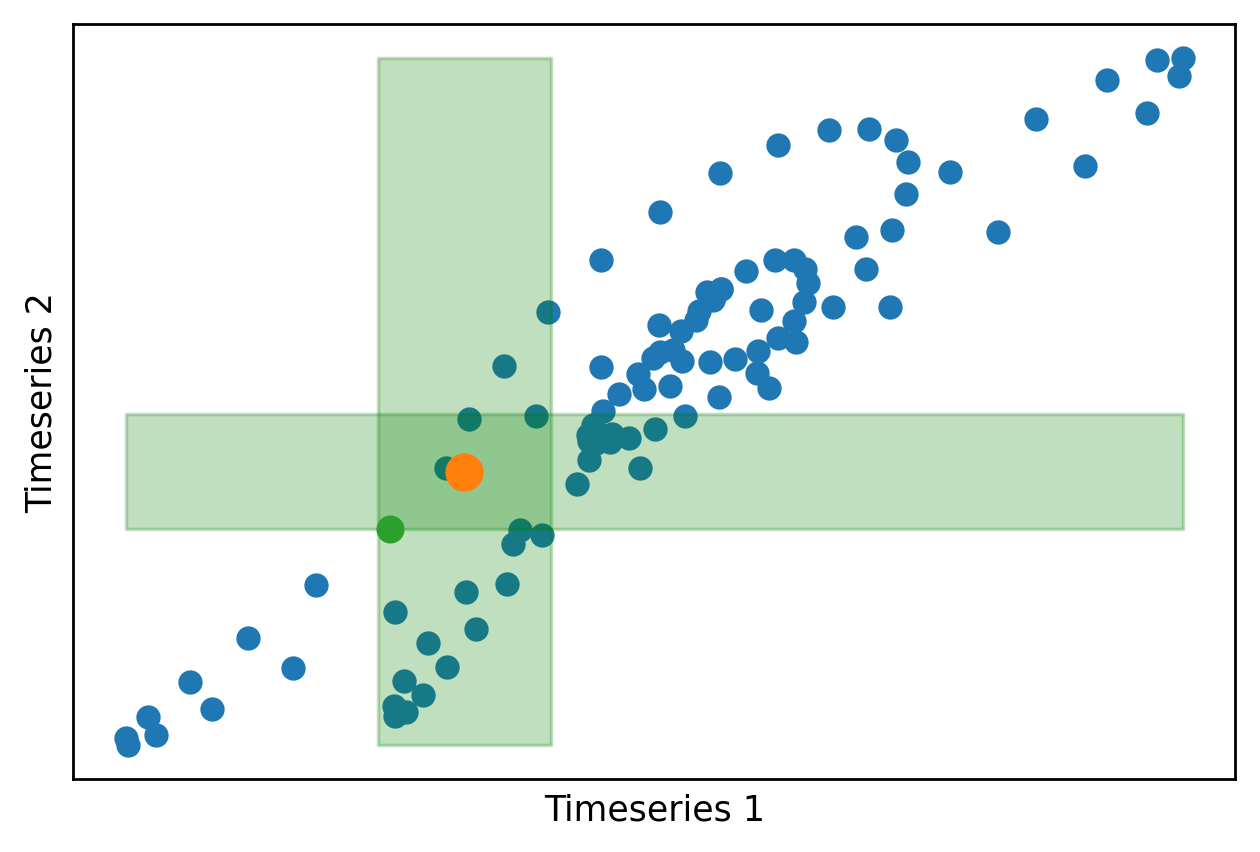